Based on 'One-Shot Speaker Identification for a Service Robot using a
CNN-based Generic Verifier'

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

from datetime import datetime
import os
%matplotlib inline

# Librispeech
Pre-processing using librosa
/class/chapter/*.wav

In [ ]:
#define x and y here
y = []
x = []

# paths = os.listdir('train-clean-100')
paths = os.listdir('/data/ml/dataset/train-clean-360/LibriSpeech/train-clean-360')
paths = sorted(paths)

print(paths)
classe = 0
for path in paths:
#     path_name = os.path.join('./', 'dataset', path)
#     path_name = os.path.join('./', 'train-clean-100', path)
    path_name = os.path.join('/data/ml/dataset/train-clean-360/LibriSpeech', 'train-clean-360', path)
    for folder in os.listdir(path_name):
        foldername = os.path.join(path_name, folder)
        for file in os.listdir(foldername):
            if ".txt" in file: #verify file extension to open
                continue #skip iteration
            filename = os.path.join(foldername, file)
            audio, sr = librosa.load(filename, sr=22000, duration=2, mono=True) #sr=44100
#             processed = librosa.feature.mfcc(y=audio, sr=sr)
            processed = librosa.feature.melspectrogram(y=audio, sr=sr)#hop_length=1024)
            if (processed.shape == (128, 86)):
                x.append(processed)
                y.append(np.array(classe))
                print(filename, processed.shape)
            else :
                print("PATTERN BREAKER"+filename, processed.shape)
#             print("processed:",len(processed))
#             print("processed[0]:",len(processed[0]))
#             print("processed[0][0]:",len(processed[0][0]))
#             print(np.array(classe))
    classe +=1


In [ ]:
num_classes = len(paths)

In [ ]:
print(len(x))
print(num_classes)

In [ ]:
# x = np.array(x)
# print(x.shape)
# y = np.array(y)
# print(y.shape)

# open the file for writing
now = datetime.now().strftime('%Y-%m-%d-%H:%M')
file_Name = 'x_2secmelspectogram_libtc360'+ now
fileObject = open(file_Name,'wb')
pickle.dump(x,fileObject)

file_Name = 'y_2secmelspectogram_libtc360'+ now
fileObject = open(file_Name,'wb')
pickle.dump(y,fileObject)

fileObject.close()

In [2]:
# x_file_Name = "x_2secmelspectogram_libtc3602019-11-13-07:10"
# y_file_Name = "y_2secmelspectogram_libtc3602019-11-13-07:10"

# num_classes = 921

x_file_Name = "x_2secmelspectogram_libtc1002019-10-14-13:33"
y_file_Name = "y_2secmelspectogram_libtc1002019-10-14-13:33"

#"x_2secmelspectogram_libtc1002019-10-10-15:07"
#"y_251classes_2secmelspectogram_libtc1002019-10-10-15:07"

num_classes = 251

x_fileObject = open(x_file_Name,'rb')  
y_fileObject = open(y_file_Name,'rb')
# load the object from the file into var b
x = pickle.load(x_fileObject)  
y = pickle.load(y_fileObject)

print(len(x))
print(len(y))

28521
28521


In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPool2D, GlobalMaxPool2D, Activation, Flatten, Reshape, ZeroPadding2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, concatenate, merge
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import optimizers

from sklearn.model_selection import KFold,StratifiedKFold

Using TensorFlow backend.
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [3]:
def reset_weights(model):
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [4]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13115568848274481448
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7405545063
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16493445186375303930
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0


In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
# xp1 = x.tolist() #used if x is np.array, but this kills the kernel :/
xp1 = x[:]
yp1 = y[:]

minexamples = 1000
smallestclass = -1

for i in range(num_classes):
    thismin = y.count(i) #len(np.where(y == i)[0])
#     print (thismin)
    if thismin < minexamples :
        minexamples = thismin
        smallestclass = i
        
print("smallest class: %d with %d"%(smallestclass,minexamples))
# start = y.index(205)
# print(start)
# print(*y[start:start+26])

x_s, y_s = shuffle(x, y, random_state=22)

xp2 = (x[-minexamples//2:] + x[:-minexamples//2] + x_s[:(len(x)//2)])
yp2 = (y[-minexamples//2:] + y[:-minexamples//2] + y_s[:(len(y)//2)])

x_s, y_s = shuffle(x, y, random_state=21)

xp1 = x[:] + x_s[:(len(x)//2)] 
yp1 = y[:] + y_s[:(len(y)//2)]

print(len(xp1))
print(len(xp2)) 

# xp1.insert(0,*x[-1:])
# yp1.insert(0,*y[-1:])
# xp2.append(*x[0:1])
# yp2.append(*y[0:1])

# print(str(len(xp1))+" "+str(len(xp2)))

# xp2 = np.concatenate([xp1[-1:]],xp1)
# xp2 = np.insert(0,xp1[len(xp1)-1])
# print("%d %d"%(len(xp1),len(xp2)))

smallest class: 205 with 26
42781
42781


In [8]:
# print(len(x))
# print(len(xp1))
# print(len(yp1))
# print(yp1[0])
# print(yp2[0])

# print(yp1[-1])
# print(yp2[-1])
# print(*yp1)
# print(*yp1)

In [9]:
y_train_b = []

for i in range(len(yp1)):
    if yp1[i] == yp2[i]:
        y_train_b.append(1)
#         print("%d and %d" %(yp1[i],yp2[i]))
    else:
        y_train_b.append(0)
        
xp1, xp2, y_train_b = shuffle(xp1, xp2, y_train_b, random_state=21)
y_c_train = to_categorical(y_train_b, 2)

In [10]:
xp1 = np.array(xp1)
print(xp1.shape)
xp2 = np.array(xp2)
print(xp2.shape)

yp1 = np.array(yp1)
print(yp1.shape)
yp2 = np.array(yp2)
print(yp2.shape)

y_train_b = np.array(y_train_b)
print(y_train_b.shape)

y_c_train = np.array(y_c_train)
print(y_c_train.shape)

(42781, 128, 86)
(42781, 128, 86)
(42781,)
(42781,)
(42781,)
(42781, 2)


In [ ]:
# #one-hot
# y_c = to_categorical(y, num_classes)
# print(y_c.shape) 

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     x.reshape(*x.shape, 1), y_c, test_size=0.33, random_state=22, stratify=y)

# X_train, X_test, y_train, y_test = train_test_split(
#     x.reshape(*x.shape, 1), y, test_size=0.33, random_state=22, shuffle=False)



In [ ]:
# X_train_l_s, y_train_l_s = shuffle(X_train, y_train)#, random_state=0)
# X_train_r_s, y_train_r_s = shuffle(X_train, y_train)
# y_train_b = []

# for i in range(y_train.shape[0]):
#     if y_train_l_s[i] == y_train_r_s[i]:
#         y_train_b.append(1)
#     else:
#         y_train_b.append(0)
        

In [11]:
count = 0
for i in range(len(yp1)):#(y_train_l_s.shape[0]):
    if y_train_b[i] == 1:
        count = count + 1
#     else:
#         print(yp1[i])
#         print(yp2[i])
#         print(*yp2)
        
print(str(count) + " out of " + str(len(yp1)))

X_train_l = xp1.reshape(*xp1.shape, 1)
X_train_r = xp2.reshape(*xp2.shape, 1)

25328 out of 42781


In [ ]:
# positions_l_s = []
# positions_r_s = []

# for i in range(num_classes):
# #     print(np.where(y == 1)[0])
#     positions_l_s.append(np.where(y_train_l_s == i)[0])
#     positions_r_s.append(np.where(y_train_r_s == i)[0])
    
# #     print("Class"+str(i))
#     print(len(np.where(y_train_l_s == i)[0]))
#     print(np.where(y_train_l_s == i)[0])
#     print(len(np.where(y_train_r_s == i)[0]))
#     print(np.where(y_train_r_s == i)[0])
    

In [ ]:
# # print(positions_l_s)
# # print(positions_r_s)
# len(positions_l_s[0])
# y_train_l_s[122]

# balanced_x = []
# balanced_y = []

# for i in range(num_classes):
#     for j in range(len(positions_l_s[i])//2):
#         balanced_y.append(y_train_l_s[positions_l_s[j]])

https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras

In [17]:
#Siamese Network
#Functional

# left = X_train
# right = X_train

in_shape = (X_train_l.shape[1],X_train_l.shape[2],1)
left_input = Input(in_shape)
right_input = Input(in_shape)

left = Conv2D(64, (3,3), activation='relu')(left_input)
left = BatchNormalization()(left)
left = Conv2D(64, (3,3), activation='relu')(left)
left = MaxPooling2D((2, 2))(left)
left = Conv2D(128, (3,3), activation='relu')(left)
left = BatchNormalization()(left)
left = Conv2D(128, (3,3), activation='relu')(left)
left = MaxPooling2D((2, 2))(left)
left = Conv2D(256, (3,3), activation='relu')(left)
left = BatchNormalization()(left)
left = Conv2D(256, (3,3), activation='relu')(left)
left = MaxPooling2D((2, 2))(left)


right = Conv2D(64, (3,3), activation='relu')(right_input)
right = BatchNormalization()(right)
right = Conv2D(64, (3,3), activation='relu')(right)
right = MaxPooling2D((2, 2))(right)
right = Conv2D(128, (3,3), activation='relu')(right)
right = BatchNormalization()(right)
right = Conv2D(128, (3,3), activation='relu')(right)
right = MaxPooling2D((2, 2))(right)
right = Conv2D(256, (3,3), activation='relu')(right)
right = BatchNormalization()(right)
right = Conv2D(256, (3,3), activation='relu')(right)
right = MaxPooling2D((2, 2))(right)

both = concatenate([left,right])
both = Flatten()(both)
both = Dense(1024, activation='relu')(both)
both = Dense(1024, activation='relu')(both)
both = Dense(2)(both)
out = Activation('softmax')(both)

# networkoptimizer = optimizers.Adam(lr=0.001)
networkoptimizer = optimizers.SGD(lr=0.01, decay=0.0001, momentum=0.9, nesterov=True)

model = Model([left_input, right_input], out)
model.compile(loss='categorical_crossentropy',
              optimizer=networkoptimizer,
              metrics=['accuracy'])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 86, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 86, 1)   0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 126, 84, 64)  640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 126, 84, 64)  640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [ ]:
###
#my take: last layer with sigmoid and with loss binary_crossentropy
#try original later: last layer with softmax and with loss categorical_crossentropy 
###

#try later: L1 difference instead of concatenate on merge


In [ ]:
history = out_model.fit([X_train_l,X_train_r], y_c_train, validation_split=0.3, batch_size= 32, epochs=120,
    callbacks=[
            EarlyStopping(patience=100, monitor="val_loss", verbose=1),
                          CSVLogger('voice_recognition.log')
]) 
#batch_size=50, epochs=15 

In [ ]:
4 952 789 138

2020-02-21-16:50

Fold  0
Train on 28520 samples, validate on 14261 samples
Epoch 1/240
   96/28520 [..............................] - ETA: 1:45:07 - loss: 4.5370 - acc: 0.5208

/home/lucas/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238191). Check your callbacks.
  % delta_t_median)


28520/28520 [==============================] - 162s 6ms/step - loss: 0.7478 - acc: 0.5868 - val_loss: 0.6767 - val_acc: 0.5913
Epoch 2/240
28520/28520 [==============================] - 140s 5ms/step - loss: 0.6770 - acc: 0.5918 - val_loss: 0.6775 - val_acc: 0.5911
Epoch 3/240
28520/28520 [==============================] - 141s 5ms/step - loss: 0.6763 - acc: 0.5926 - val_loss: 0.6775 - val_acc: 0.5914
Epoch 4/240
28520/28520 [==============================] - 143s 5ms/step - loss: 0.6759 - acc: 0.5927 - val_loss: 0.6778 - val_acc: 0.5911
Epoch 5/240
28520/28520 [==============================] - 142s 5ms/step - loss: 0.6751 - acc: 0.5946 - val_loss: 0.7168 - val_acc: 0.5180
Epoch 6/240
28520/28520 [==============================] - 143s 5ms/step - loss: 0.6610 - acc: 0.6205 - val_loss: 0.6481 - val_acc: 0.6368
Epoch 7/240
28520/28520 [==============================] - 141s 5ms/step - loss: 0.5915 - acc: 0.6941 - val_loss: 0.5464 - val_acc: 0.7292
Epoch 8/240
28520/28520 [==============

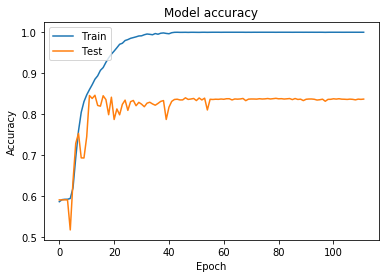

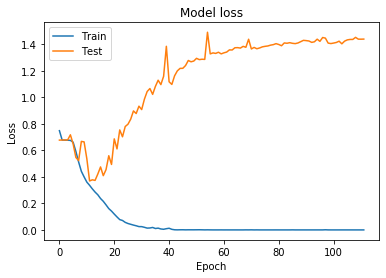

153/153 [==============================] - 1s 3ms/step
[1.5971974079904994, 0.8300653614249884]

Fold  1
Train on 28521 samples, validate on 14260 samples
Epoch 1/240
28521/28521 [==============================] - 157s 6ms/step - loss: 0.6977 - acc: 0.5865 - val_loss: 0.6764 - val_acc: 0.5932
Epoch 2/240
28521/28521 [==============================] - 141s 5ms/step - loss: 0.6762 - acc: 0.5918 - val_loss: 0.6820 - val_acc: 0.5924
Epoch 3/240
28521/28521 [==============================] - 141s 5ms/step - loss: 0.6732 - acc: 0.5966 - val_loss: 0.6575 - val_acc: 0.6309
Epoch 4/240
28521/28521 [==============================] - 141s 5ms/step - loss: 0.6066 - acc: 0.6848 - val_loss: 0.5804 - val_acc: 0.7096
Epoch 5/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.5213 - acc: 0.7519 - val_loss: 0.6785 - val_acc: 0.6279
Epoch 6/240
28521/28521 [==============================] - 141s 5ms/step - loss: 0.4760 - acc: 0.7844 - val_loss: 0.4665 - val_acc: 0.7916
Epoch 7/240

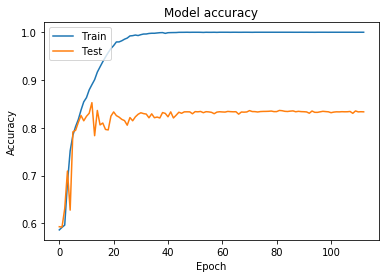

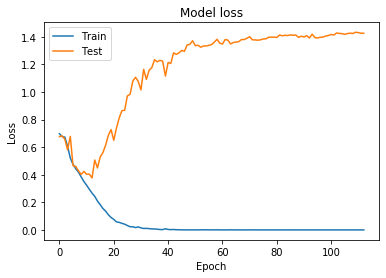

153/153 [==============================] - 0s 1ms/step
[2.8471179133147198, 0.7124182990953034]

Fold  2
Train on 28521 samples, validate on 14260 samples
Epoch 1/240
28521/28521 [==============================] - 147s 5ms/step - loss: 0.7285 - acc: 0.5884 - val_loss: 0.6787 - val_acc: 0.5919
Epoch 2/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.6737 - acc: 0.5946 - val_loss: 0.6689 - val_acc: 0.5921
Epoch 3/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.6282 - acc: 0.6576 - val_loss: 0.9158 - val_acc: 0.4798
Epoch 4/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.5330 - acc: 0.7424 - val_loss: 0.5848 - val_acc: 0.7055
Epoch 5/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.4651 - acc: 0.7902 - val_loss: 0.4627 - val_acc: 0.7871
Epoch 6/240
28521/28521 [==============================] - 143s 5ms/step - loss: 0.4172 - acc: 0.8184 - val_loss: 0.4751 - val_acc: 0.7806
Epoch 7/240

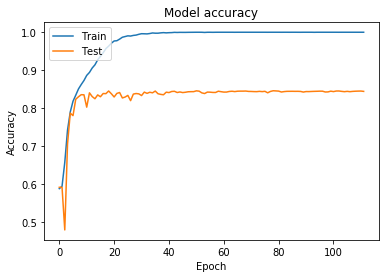

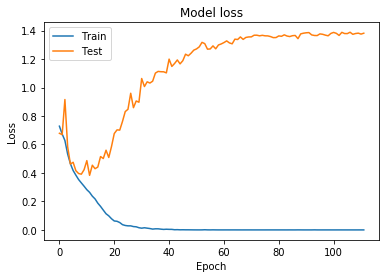

153/153 [==============================] - 0s 2ms/step
[1.5758039335799372, 0.8039215713544609]


In [18]:
# kf = StratifiedKFold(n_splits=3,shuffle=False,random_state=22)
kf = KFold(n_splits=3,shuffle=False,random_state=22)
j = 0
scores = []
now = datetime.now().strftime('%Y-%m-%d-%H:%M')
print(now)
for train_index, test_index in kf.split(X_train_l, np.argmax(y_c_train, -1)):
    reset_weights(model)
    print('\nFold ',j)
    
    X_tr_r, X_val_r = X_train_r[train_index], X_train_r[test_index]
    X_tr_l, X_val_l = X_train_l[train_index], X_train_l[test_index]
    y_tr, y_val = y_c_train[train_index], y_c_train[test_index]
    
    history = model.fit([X_tr_l,X_tr_r], y_tr, validation_data = ([X_val_l,X_val_r], y_val), batch_size= 32, epochs=240,
        callbacks=[
                EarlyStopping(patience=100, monitor="val_loss", verbose=1),
                              CSVLogger('voice_recognition.log')
    ])
    
    model.save_weights("model-"+now+"-fold"+str(j)+".h5")
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    e = model.evaluate([X_test_l,X_test_r], y_c_test)
    scores.append(e)
    print(e) #loss and accuracy
    
    j = j+1

In [21]:
# y_t = np.argmax(y_c_test, -1)

f1 = []
for j in range(3):
    model.load_weights("model-"+now+"-fold"+str(j)+".h5")
#     y_pred = model.predict(X_test)
    y_pred = model.predict([X_test_l,X_test_r])
    y_p = np.argmax(y_pred, -1)

    print(classification_report(y_b, y_p))
    f1.append((f1_score(y_b, y_p,average=None)))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        75
           1       0.81      0.87      0.84        78

    accuracy                           0.83       153
   macro avg       0.83      0.83      0.83       153
weighted avg       0.83      0.83      0.83       153

              precision    recall  f1-score   support

           0       0.80      0.55      0.65        75
           1       0.67      0.87      0.76        78

    accuracy                           0.71       153
   macro avg       0.74      0.71      0.70       153
weighted avg       0.73      0.71      0.70       153

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        75
           1       0.78      0.86      0.82        78

    accuracy                           0.80       153
   macro avg       0.81      0.80      0.80       153
weighted avg       0.81      0.80      0.80       153



In [24]:
from math import sqrt

#average
avgs = []
nclasses = 2
nfolds = 3

for i in range(nclasses):
    f1_class_sum = 0
    for j in range(nfolds):
        f1_class_sum = f1_class_sum+f1[j][i] 
#     sums.append(f1_class_sum)
    f1_class_avg = f1_class_sum/nfolds
    avgs.append(f1_class_avg)

#standard deviation
sd = []
for i in range (nclasses):
    sq_sum = 0
    for j in range(nfolds):
        sq_sum = sq_sum + (f1[j][i]-avgs[i])**2
    f1_class_sd = sqrt(sq_sum/(nfolds-1))   
    sd.append(f1_class_sd)
    
print(avgs)
print(sd) 

[0.7529901632014308, 0.8040449663755896]
[0.08982707201193489, 0.04346524033233523]


# Loading the model

In [26]:
# now = datetime.now().strftime('%Y-%m-%d-%H:%M')
# serialize model to JSON
model_json = model.to_json()
with open("modelkfoldoneshot.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# out_model.save_weights("modelregister-"+now+".h5")
# print("Saved model to disk", now)

In [7]:
# load json and create model
json_file = open('modelkfoldoneshot.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model

loaded_model.load_weights("model-2020-02-21-16:50-fold0.h5")
print("Loaded model from disk")

networkoptimizer = optimizers.SGD(lr=0.01, decay=0.0001, momentum=0.9, nesterov=True)
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=networkoptimizer,
              metrics=['accuracy'])

Loaded model from disk


# Testing with my dataset

In [ ]:
y = []
x = []

paths = os.listdir('telemidia-ds')
paths = sorted(paths)

print(paths)
classe = 0
for path in paths:
    path_name = os.path.join('./', 'telemidia-ds', path)
    for file in os.listdir(path_name):
        filename = os.path.join(path_name, file)
        audio, sr = librosa.load(filename, sr=22000, duration=2, mono=True)
        processed = librosa.feature.melspectrogram(y=audio, sr=sr)
        if (processed.shape == (128, 86)):
            x.append(processed)
            y.append(np.array(classe))
            print(filename, processed.shape)
        else :
            print("PATTERN BREAKER"+filename, processed.shape)
        
    classe +=1
    
num_classes = len(paths)

In [ ]:
# open the file for writing
now = datetime.now().strftime('%Y-%m-%d-%H:%M')
file_Name = 'x_2secmelspectogram_telds'+ now
fileObject = open(file_Name,'wb')
pickle.dump(x,fileObject)

file_Name = 'y_2secmelspectogram_telds'+ now
fileObject = open(file_Name,'wb')
pickle.dump(y,fileObject)

fileObject.close()
print("Saved pickle to disk", now)

In [8]:
x_file_Name = "x_2secmelspectogram_telds2019-10-18-12:06"
y_file_Name = "y_2secmelspectogram_telds2019-10-18-12:06"

#"x_2secmelspectogram_libtc1002019-10-10-15:07"
#"y_251classes_2secmelspectogram_libtc1002019-10-10-15:07"train

num_classes = 3

x_fileObject = open(x_file_Name,'rb')  
y_fileObject = open(y_file_Name,'rb')
# load the object from the file into var b
x = pickle.load(x_fileObject)  
y = pickle.load(y_fileObject)

print("Loaded pickle from disk")


Loaded pickle from disk


In [9]:
# xp1 = x.tolist() #used if x is np.array, but this kills the kernel :/
xp1 = x[:]
yp1 = y[:]

minexamples = 1000
smallestclass = -1

for i in range(num_classes):
    thismin = y.count(i) #len(np.where(y == i)[0])
#     print (thismin)
    if thismin < minexamples :
        minexamples = thismin
        smallestclass = i
        
print("smallest class: %d with %d"%(smallestclass,minexamples))
# start = y.index(205)
# print(start)
# print(*y[start:start+26])

x_s, y_s = shuffle(x, y, random_state=22)

xp2 = (x[-minexamples//2:] + x[:-minexamples//2] + x_s[:(len(x)//2)])
yp2 = (y[-minexamples//2:] + y[:-minexamples//2] + y_s[:(len(y)//2)])

x_s, y_s = shuffle(x, y, random_state=21)

xp1 = x[:] + x_s[:(len(x)//2)] 
yp1 = y[:] + y_s[:(len(y)//2)]

print(len(xp1))
print(len(xp2)) 

smallest class: 1 with 30
153
153


In [10]:
y_b = []

count = 0
for i in range(len(yp1)):
    if yp1[i] == yp2[i]:
        y_b.append(1)
        count = count + 1
#         print("%d and %d" %(yp1[i],yp2[i]))
    else:
        y_b.append(0)
        
xp1, xp2, y_b = shuffle(xp1, xp2, y_b, random_state=21)
y_c_test = to_categorical(y_b, 2)

print(str(count) + " out of " + str(len(yp1)))

xp1 = np.array(xp1)
print(xp1.shape)
xp2 = np.array(xp2)
print(xp2.shape)

yp1 = np.array(yp1)
print(yp1.shape)
yp2 = np.array(yp2)
print(yp2.shape)

y_b = np.array(y_b)
print(y_b.shape)

y_c_test = np.array(y_c_test)
print(y_c_test.shape)

X_test_l = xp1.reshape(*xp1.shape, 1)
X_test_r = xp2.reshape(*xp2.shape, 1)

78 out of 153
(153, 128, 86)
(153, 128, 86)
(153,)
(153,)
(153,)
(153, 2)


In [11]:
y_pred = loaded_model.predict([X_test_l,X_test_r])

for i in range(len(y_pred)):
    print(y_pred[i],y_c_test[i])

[2.5539513e-05 9.9997449e-01] [1. 0.]
[9.9987662e-01 1.2341907e-04] [0. 1.]
[0.00453921 0.9954608 ] [0. 1.]
[1.3273789e-09 1.0000000e+00] [0. 1.]
[0.85085404 0.149146  ] [1. 0.]
[3.2417734e-08 1.0000000e+00] [0. 1.]
[1.0000000e+00 9.0282664e-13] [1. 0.]
[1.792021e-05 9.999821e-01] [0. 1.]
[1.0823216e-09 1.0000000e+00] [0. 1.]
[1.000000e+00 5.018504e-16] [1. 0.]
[0.85963374 0.14036626] [1. 0.]
[2.6717723e-08 1.0000000e+00] [0. 1.]
[0.78669107 0.21330898] [0. 1.]
[2.9397356e-07 9.9999976e-01] [0. 1.]
[9.9998486e-01 1.5092358e-05] [1. 0.]
[0.898733   0.10126695] [1. 0.]
[0.25025162 0.7497484 ] [0. 1.]
[0.00610646 0.99389356] [0. 1.]
[0.62660414 0.37339583] [1. 0.]
[9.9999630e-01 3.6400202e-06] [1. 0.]
[3.3427266e-08 1.0000000e+00] [0. 1.]
[1.3646127e-12 1.0000000e+00] [0. 1.]
[0.01144048 0.98855954] [1. 0.]
[0.8857372  0.11426283] [1. 0.]
[8.9825784e-07 9.9999905e-01] [0. 1.]
[0.9687075  0.03129252] [1. 0.]
[9.9999988e-01 1.0485009e-07] [1. 0.]
[1.000000e+00 8.122949e-13] [1. 0.]
[0.57944

In [12]:
score = loaded_model.evaluate([X_test_l,X_test_r], y_c_test, verbose=0) 
print(score)

[1.5971981871361827, 0.8300653614249884]


In [15]:
y_p = np.argmax(y_pred,-1)
y_p

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [17]:
confusion_matrix(y_b, y_p)

array([[59, 16],
       [10, 68]])

In [18]:
print(classification_report(y_b, y_p))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        75
           1       0.81      0.87      0.84        78

    accuracy                           0.83       153
   macro avg       0.83      0.83      0.83       153
weighted avg       0.83      0.83      0.83       153



In [ ]:
X_test_r.shape